In [1]:
import time
import pickle
import warnings
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm

seed=42

In [2]:
# loading trained baseline model
with open("baseline_model.pkl", "rb") as r:
    basemodel = pickle.load(r)

basemodel

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(encoding_method='arbitrary',
                                                 variables=['GEOHASH',
                                                            'DISTRICT',
                                                            'LOCATION_TYPE',
                                                            'HOLIDAY_NAME',
                                                            'HOLIDAY_TYPE',
                                                            'SCHOOL_HOLIDAY_TYPE'])),
                                 ('cyclicalfeatures',
                                  CyclicalFeatures(drop_original=True,
                                                   variables=['DAY', 'MONTH',
                                                              'HOUR',
                                                              'DAYOFWEEK']))])),
                ('xgbregressor',
                 XGBRegressor(base_sc...
                              eval_metric='rmse', feature_types=None, gamma=2,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=-1, num_parallel_tree=None, predictor=None, ...))])

# Preparing test set

In [3]:
top_TD_GH_by_district = np.array(
    pl.scan_parquet("datasets/19_model/train.zstd")
    .groupby(['DISTRICT', 'GEOHASH'])
    .agg(pl.col(['NUMBER_OF_VEHICLES']).mean())
    .sort(['DISTRICT', 'NUMBER_OF_VEHICLES'], descending=True)
    .with_columns(pl.col('NUMBER_OF_VEHICLES').rank('dense', descending=True).over('DISTRICT').alias('TD_row'))
    .filter(pl.col('TD_row').le(20))
    .select('GEOHASH')
    .collect(streaming=True)\
        ['GEOHASH']
    .to_list()
    # .to_pandas()
    # .to_excel("datasets/18_Viz/top_10_td_gh_district.xlsx", index=False)
)

len(top_TD_GH_by_district)

720

In [4]:
stadium_df = (
    pl.read_csv("datasets/13_gh_proximities/gh_nearby_stadiums.csv")
    .filter(pl.col('type').eq('geohash'))
    .select(pl.col('name').cast(pl.Categorical).alias('GEOHASH'))
    .with_columns(pl.lit(1).alias('IS_NEARBY_STADIUM'))
)

stadium_df.head()

GEOHASH,IS_NEARBY_STADIUM
cat,i32
"""sxk3zw""",1
"""sxk3zt""",1
"""sxk3zx""",1
"""sxk97m""",1
"""sxk97q""",1


In [5]:
# Preparing test set
X_test = (
    pl.read_parquet("datasets/19_model/test.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .drop('NUMBER_OF_VEHICLES')
    .join(stadium_df, on='GEOHASH', how='left')
    .with_columns(pl.col('IS_NEARBY_STADIUM').fill_null(0).cast(pl.Boolean))
    .to_pandas()

    # Replacing all TD_LAG1 except for the first hour
    .assign(TD_LAG1=lambda x: np.where(x['DATE_TIME'].eq("2023-04-01 00:00:00"), x['TD_LAG1'], np.nan))
    .set_index('DATE_TIME')
)

y_test = (
    pl.read_parquet("datasets/19_model/test.zstd")
    .filter(pl.col('GEOHASH').is_in(top_TD_GH_by_district))
    .select(['DATE_TIME', 'NUMBER_OF_VEHICLES'])
    .to_pandas()
    .set_index('DATE_TIME')
)

X_test.head()

,GEOHASH,DISTRICT,LOCATION_TYPE,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,HOLIDAY_NAME,HOLIDAY_TYPE,SCHOOL_HOLIDAY_TYPE,HIGHWAY_TRNSPRT_PSNGRS,...,SNOW,TD_LAG1,RAIN_LAG1,SNOW_LAG1,YEAR,MONTH,DAY,HOUR,DAYOFWEEK,IS_NEARBY_STADIUM
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2023-04-01,sxk90n,Bahçelievler,avenue,628203,641667,1289903,Ramadan Observance,Ramadan Observance,Non Holiday,14754,...,0.0,305.0,0.0,0.0,2023,4,1,0,6,False
2023-04-01,sxk3pn,Küçükçekmece,avenue,628203,641667,1289903,Ramadan Observance,Ramadan Observance,Non Holiday,14754,...,0.0,259.0,0.0,0.0,2023,4,1,0,6,False
2023-04-01,sxkcd0,Çekmeköy,street,628203,641667,1289903,Ramadan Observance,Ramadan Observance,Non Holiday,14754,...,0.0,137.0,0.0,0.0,2023,4,1,0,6,False
2023-04-01,sxk97t,Beyoğlu,other,628203,641667,1289903,Ramadan Observance,Ramadan Observance,Non Holiday,14754,...,0.0,71.0,0.0,0.0,2023,4,1,0,6,False
2023-04-01,sxk3w7,Başakşehir,street,628203,641667,1289903,Ramadan Observance,Ramadan Observance,Non Holiday,14754,...,0.0,168.0,0.0,0.0,2023,4,1,0,6,False


In [6]:
len(X_test)

518400

In [7]:
len(y_test)

518400

In [8]:
len(X_test['GEOHASH'].unique())

720

In [9]:
X_test[['GEOHASH', 'DISTRICT']]

,GEOHASH,DISTRICT
DATE_TIME,,
2023-04-01 00:00:00,sxk90n,Bahçelievler
2023-04-01 00:00:00,sxk3pn,Küçükçekmece
2023-04-01 00:00:00,sxkcd0,Çekmeköy
2023-04-01 00:00:00,sxk97t,Beyoğlu
2023-04-01 00:00:00,sxk3w7,Başakşehir
...,...,...
2023-04-30 23:00:00,sxk3nt,Küçükçekmece
2023-04-30 23:00:00,sxkc62,Sancaktepe
2023-04-30 23:00:00,sxk9e3,Şişli


In [10]:
test_td_forecast_df = (
    pd.concat([X_test[['GEOHASH', 'DISTRICT']], y_test], axis=1)
    .assign(forecast=np.nan)
)

test_td_forecast_df.head()

,GEOHASH,DISTRICT,NUMBER_OF_VEHICLES,forecast
DATE_TIME,,,,
2023-04-01,sxk90n,Bahçelievler,262,NaN
2023-04-01,sxk3pn,Küçükçekmece,208,NaN
2023-04-01,sxkcd0,Çekmeköy,123,NaN
2023-04-01,sxk97t,Beyoğlu,51,NaN
2023-04-01,sxk3w7,Başakşehir,151,NaN


## Forecasting

In [11]:
forecast_horizon = pd.date_range("2023-04-01 00:00:00", "2023-04-30 23:00:00", freq='H')

In [12]:
for date in tqdm(forecast_horizon):

    if date==pd.to_datetime("2023-04-01 00:00:00"):
        
        X = X_test.loc[date]
        forecast = basemodel.predict(X)
        test_td_forecast_df.loc[date, 'forecast'] = forecast

    else:
        # assign previous hour forecast TD to current hour TD_LAG1
        X_test.loc[date, "TD_LAG1"] = test_td_forecast_df.loc[date-pd.offsets.Hour(1), "forecast"].values

        X = X_test.loc[date]
        forecast = basemodel.predict(X)
        test_td_forecast_df.loc[date, 'forecast'] = forecast

  0%|          | 0/720 [00:00<?, ?it/s]

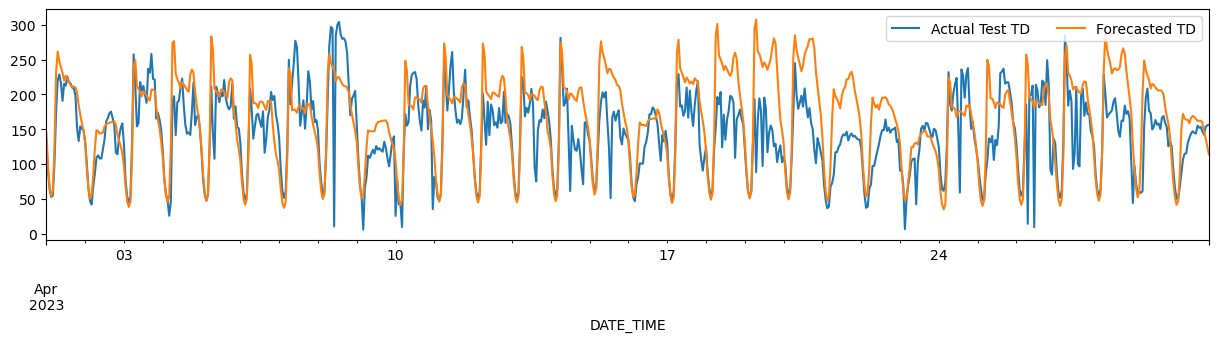

In [13]:
ax = (
    test_td_forecast_df
    .resample('H')[['NUMBER_OF_VEHICLES', 'forecast']].mean()
    .plot(figsize=(15, 3))
)

ax.legend(labels=["Actual Test TD", "Forecasted TD"], ncol=2, loc="upper right");